# **1. GAN 모델 만들기**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

from tqdm import tqdm
from PIL import Image
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop


In [ ]:
IMAGES_COUNT = 10000

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

In [ ]:
LATENT_DIM = 32
CHANNELS = 3

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

In [ ]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

In [ ]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

In [ ]:
generator = create_generator()
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      104883

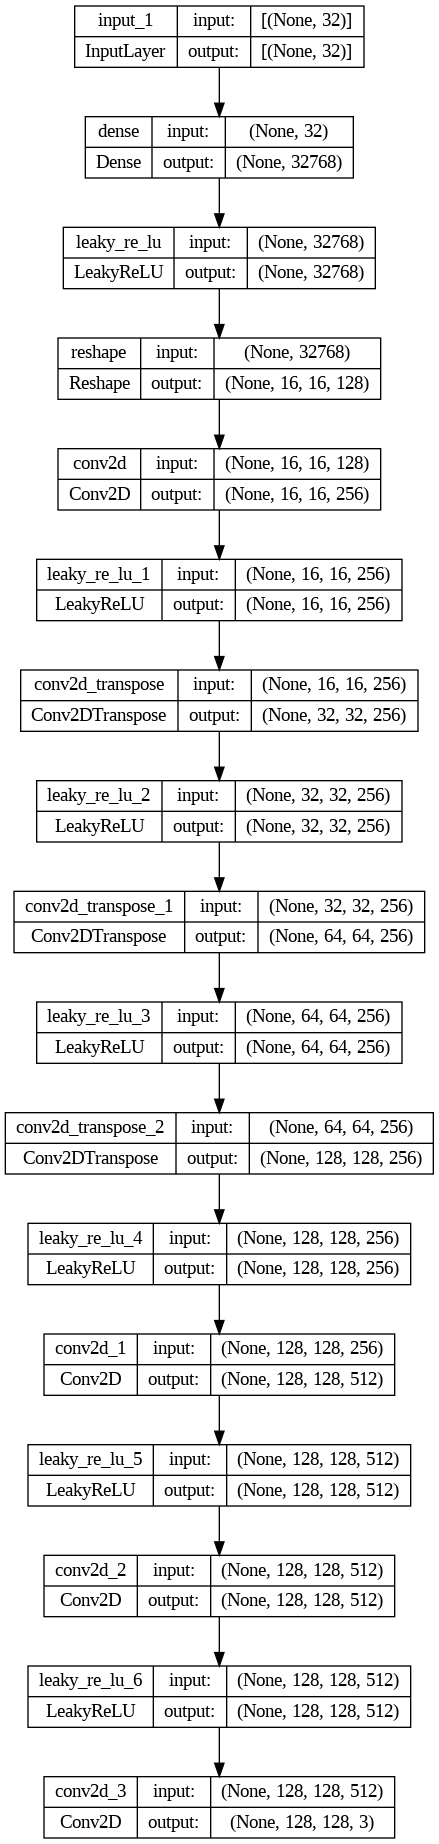

In [ ]:
Image(model_to_dot(generator, show_shapes=True).create_png())

In [ ]:
discriminator = create_discriminator()
discriminator.trainable = False
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 256)     7168      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 126, 126, 256)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 256)       1048832   
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 62, 62, 256)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       1048832   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 30, 30, 256)       0   

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


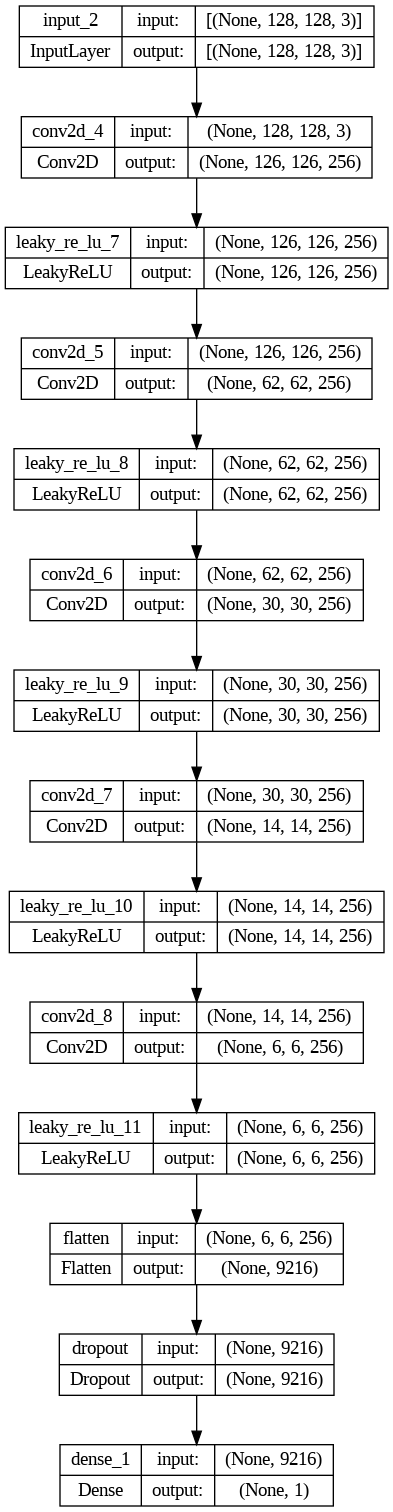

In [ ]:
Image(model_to_dot(discriminator, show_shapes=True).create_png())

In [ ]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

In [ ]:
optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')


In [ ]:
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 model (Functional)          (None, 128, 128, 3)       14953987  
                                                                 
 model_1 (Functional)        (None, 1)                 4211713   
                                                                 
Total params: 19,165,700
Trainable params: 14,953,987
Non-trainable params: 4,211,713
_________________________________________________________________


# **2. Load Weights for GAN**

In [ ]:
print("gan.get_weights()[0].shape : ", gan.get_weights()[0].shape)
gan.get_weights()[0]

gan.get_weights()[0].shape :  (32, 32768)


array([[ 0.00919668,  0.01087953,  0.00169338, ...,  0.01267854,
        -0.00128481, -0.00068498],
       [-0.00089226, -0.00429261,  0.00469867, ..., -0.00804851,
        -0.00376927, -0.01291713],
       [ 0.0057209 , -0.00645156,  0.00429527, ...,  0.00072312,
         0.01221112,  0.00545571],
       ...,
       [ 0.00798945, -0.00981303,  0.00643056, ..., -0.00040393,
        -0.00959263, -0.00068747],
       [ 0.00612259, -0.00623143, -0.00347527, ...,  0.00836786,
        -0.00142675,  0.00588063],
       [-0.00996091, -0.00389043, -0.00981927, ..., -0.00492308,
         0.00882794, -0.01209151]], dtype=float32)

In [ ]:
path_weights = "/content/drive/MyDrive/Colab Notebooks/Python_AI/5_딥러닝_선생님/5_GAN/weights/gan.h5"

In [ ]:
gan.load_weights(path_weights)

In [ ]:
gan.get_weights()[0]

array([[ 0.01713534, -0.00394934,  0.01395174, ..., -0.00337651,
         0.00261293,  0.01408462],
       [ 0.02661736, -0.0057089 ,  0.01214413, ...,  0.01128927,
        -0.00281974, -0.02665969],
       [-0.01413748, -0.00129509,  0.00258796, ..., -0.02325497,
         0.00244111,  0.0048816 ],
       ...,
       [ 0.01071672,  0.00109498,  0.00641525, ..., -0.01895215,
        -0.01623483, -0.00848755],
       [-0.00304954,  0.00058246,  0.02124851, ..., -0.00810401,
        -0.00780881,  0.02091805],
       [ 0.00556131, -0.00091911, -0.01777119, ...,  0.02345788,
         0.00324655, -0.00553436]], dtype=float32)

> 아래는 이미지를 생성해낼 수 있는 코드입니다.

In [ ]:
temp_batch_size = 16
temp_latent_vectors = np.random.normal(size=(temp_batch_size, LATENT_DIM))
temp_generated = generator.predict(temp_latent_vectors)

1/1 [==============================] - 77s 77s/step


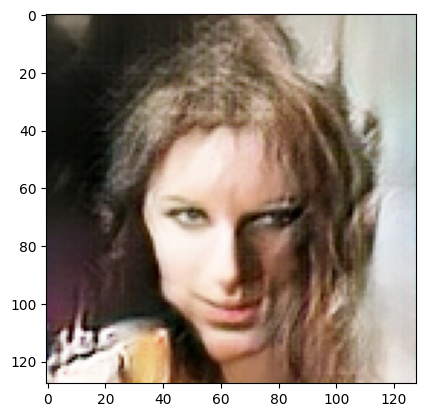

In [ ]:
plt.imshow(temp_generated[0])

In [ ]:
np.random.normal(size = (16,32))

array([[-2.58039516e+00, -1.34738352e-01,  6.61341895e-01,
        -9.73927979e-02, -1.31494303e+00,  8.41184945e-01,
         5.74825143e-01,  7.64386141e-01,  2.08448511e+00,
        -1.26059249e+00, -1.50394219e+00, -3.25281544e-01,
         1.15448027e+00,  1.39621653e+00,  1.31946069e+00,
         1.19431036e+00, -6.97581509e-01,  5.85486464e-01,
        -1.35766059e+00, -5.87044767e-01, -1.88033863e+00,
        -1.47764006e+00,  5.52049263e-01, -1.02063908e+00,
        -2.28176770e-01,  3.77461797e-01, -4.93175707e-01,
        -7.72145299e-01, -1.62307111e-01,  4.22690313e-01,
        -8.97559913e-01, -1.40681725e+00],
       [-2.27204250e-01,  1.03850189e-01, -6.39639508e-01,
         2.39280580e-01, -2.59240800e-01, -1.30198589e+00,
        -2.66563751e-01, -3.02213129e-01, -1.59440575e+00,
         1.16609188e+00,  6.92560645e-01, -1.00452562e+00,
        -4.50713903e-01, -9.29396067e-01, -1.09133176e+00,
         5.41323600e-01,  1.82464716e+00, -7.11351943e-01,
         5.40